## Identify the "start of climate change" 
The algorithm is as follows, applied to a variable (Y):

1. Identify inflection (T0) point as "start of climate change": point where dY/dt != 0 for remainder of record
2. Compute trend (ω) from that point forward
3. Compute ToE as a timescale: ToE = 2 σ / ω
4. Year of detection = T0 + ToE

In [1]:
from itertools import product

import numpy as np
import xarray as xr
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')

In [2]:
import statsmodels

In [3]:
variables = ['SST', 'Chl_surf', 'KGP']

ds_djf = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf = ds_djf[variables].sel(length = 40).sel(region = 'Southern Ocean')
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
    region     <U17 'Southern Ocean'
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    length     float64 40.0
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [4]:
ds_ref_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_mean

Standard deviation of anomalies

In [5]:
ds_ref_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_std

### calculate and plot the anomalies relative to the reference

In [6]:
forced = ds_djf.mean('member_id')     
anom_f = forced - ds_ref_mean
#anom_f

Text(0.5, 1.0, 'Daily growth rate anomaly ')

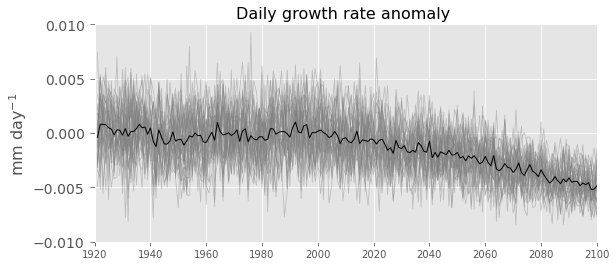

In [7]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(1,1)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)

## Calculate cumulative integrals

In [8]:
x = anom_f['time'] # The coordinate to integrate along.

# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y_k = anom_f['KGP'].values # Values to integrate.
y_int_k = xr.full_like(anom_f['KGP'], fill_value=0)
y_int_k.values = integrate.cumtrapz(y_k, x, initial=0)

y_t = anom_f['SST'].values # Values to integrate.
y_int_t = xr.full_like(anom_f['SST'], fill_value=0)
y_int_t.values = integrate.cumtrapz(y_t, x, initial=0)

y_c = anom_f['Chl_surf'].values # Values to integrate.
y_int_c = xr.full_like(anom_f['Chl_surf'], fill_value=0)
y_int_c.values = integrate.cumtrapz(y_c, x, initial=0)

### ID Inflection Point

In [9]:
# Isolate the climate change signal
x = anom_f['time'] # The coordinate to integrate along.
for l in range(len(x)): # krill
    if all(y_int_k[l:] < 0):
        ndx_k = l
        break
#krill        
x_cc_k = x[ndx_k:]
y_cc_k = y_int_k[ndx_k:]
beta_k = np.polyfit(x_cc_k, y_cc_k, 1)
bf_k = beta_k[1] + beta_k[0]*x_cc_k
        
for l in range(len(x)): # chlorophyll
    if all(y_int_c[l:] < 0):
        ndx_c = l
        break

#chlorophyll        
x_cc_c = x[ndx_c:]
y_cc_c = y_int_c[ndx_c:]
beta_c = np.polyfit(x_cc_c, y_cc_c, 1)
bf_c = beta_c[1] + beta_c[0]*x_cc_c

for l in range(len(x)): # temp
    if all(y_int_t[l:] > 0):
        ndx_t = l    
        break
#sst        
x_cc_t = x[ndx_t:]
y_cc_t = y_int_t[ndx_t:]
beta_t = np.polyfit(x_cc_t, y_cc_t, 1)
bf_t = beta_t[1] + beta_t[0]*x_cc_t

# #TEST
# plt.figure(figsize=(15, 4))
# plt.plot(x, y_int_k)
# plt.plot(x_cc_k, y_cc_k, 'o')
# plt.plot(x_cc_k, bf_k, 'g-')

### Check by plotting

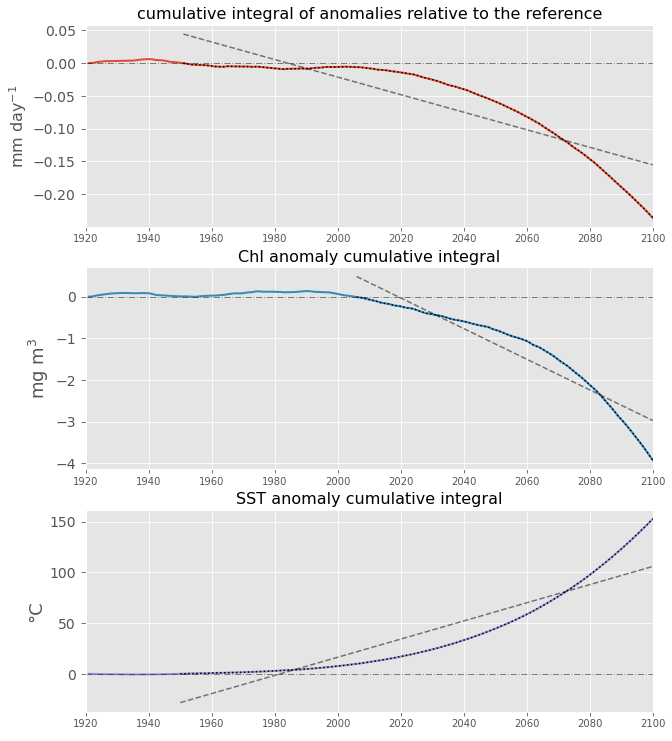

In [10]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylim([-.05, .025])
ax.plot(x, y_int_k, color = 'C0', linewidth = 2) # full time series
ax.plot(x_cc_k, y_cc_k, color = 'k', linestyle=':') # post climate change
ax.plot(x_cc_k, bf_k, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);
#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylim([-2, .5])
ax.plot(x, y_int_c, color = 'C1', linewidth = 2) # full time series
ax.plot(x_cc_c, y_cc_c, color = 'k', linestyle=':') # post climate change
ax.plot(x_cc_c, bf_c, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('Chl anomaly cumulative integral', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)
#ax.set_ylim([-1, 3])
ax.plot(x, y_int_t, color = 'C2', linewidth = 2)
ax.plot(x_cc_t, y_cc_t, color = 'k', linestyle=':')
ax.plot(x_cc_t, bf_t, '--k', alpha = .5) #best fit line
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .5)
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('SST anomaly cumulative integral', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92, right =1)

# title = ('cumulative integrals ')
# path = 'figures/'
# file = '.pdf'
# plt.savefig(path + title + file, bbox_inches='tight')

The idea here is that you're looking for a representation of the force trend. Which gives you a magnitude of quantity per time and then you divide the standard deviation by that quantity per time, and you're left with time.

* t * t sigma / by the trend gives you a time scale.
    * 2sigma / mean = timescale
* Time the year of detection is T naught plus t o.
    * tnaught + toe


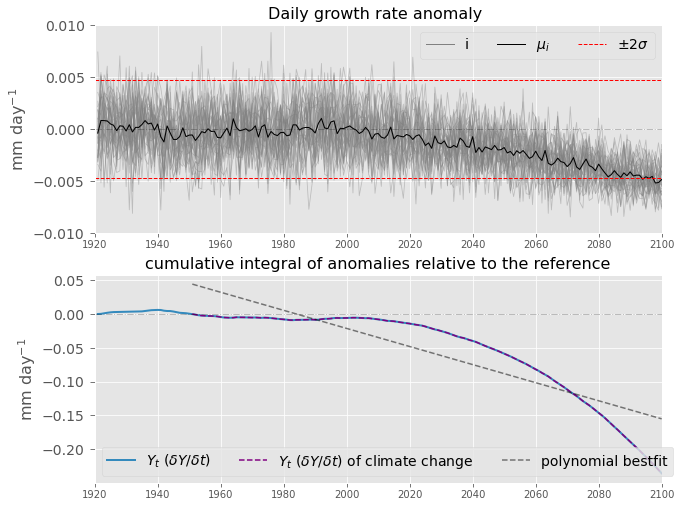

In [11]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='grey', label = 'i') # fake for sake of legend
ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma
ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma
# ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
ax.legend(ncol = 3, fontsize = 14)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly ', fontsize = 16)
#~~~~~~~    ~~~~~~~~~    ~~~~~~~~~~~    ~~~~~~~~~    ~~~~~~~~~~~    ~~~~~~~~~
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylim([-.05, .025])
ax.plot(x, y_int_k, color = 'C1', linewidth = 2, label = '$Y_t$ ($\delta Y/ \delta t$)') # full time series
ax.plot(x_cc_k, y_cc_k, color = 'purple', linestyle='--', label = '$Y_t$ ($\delta Y/ \delta t$) of climate change') # post climate change
ax.plot(x_cc_k, bf_k, '--k', alpha = .5, label = 'polynomial bestfit' ) #best fit line
ax.legend(loc = 'lower left', ncol = 3, fontsize = 14)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);

gs.update(hspace=.2, top=.92, right=1)

## Regression analysis
A generalized least-squares model with a ﬁrst-order autoregressive error term (AR(1)) was applied to time series of the annual maxima (SST) or minima (other variables) using R package ‘nlme’ 72 :

$Y_t = \mu + \omega + N_t$
* $Y_t$ = the annual extreme in the variable
* $t$ = the linear trend function (time in years)
* $\mu$ = a constant term (the intercept)
* $\omega$ = is the magnitude of the trend (the slope)
* $N_t$ = unexplained portion of the data modelled as an AR(1) process


Trends for SST are reported as °C per decade;
Trends for PP, pH and oxygen as the % change per decade with respect to the mean of 1986–2005. 

The assumption of normality in the annual extrema was checked using the Lilliefors test. 

Approximately 80% of pixels pass the test for pH and SST, and B65% for PP and oxygen. The majority of pixels failing these tests are in the Arctic.

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf